# Moving Beyond Linearity

Nonlinear functions are estimated through different regression techniques. Here, we focus on

- Polynomial regression
- Piecewise-constant regression
- Regression splines


# Load file
Commonly two libraries are used to load a csv files.
- numpy function `np.loadtext` and `np.genfromtext ` 
- pandas function `pd.read_csv`

Here we prefer using pandas

In [1]:
import pandas as pd
path='data/'
filename = path+'Wage.csv'
df = pd.read_csv(filename)

In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline

## 1-Polynomial Regression

Here, we'll explore how to generate the Wage dataset models.

In [3]:
df.head(3)

,Unnamed: 0,year,age,sex,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,231655,2006,18,1. Male,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,86582,2004,24,1. Male,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,161300,2003,45,1. Male,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 13 columns):
Unnamed: 0    3000 non-null int64
year          3000 non-null int64
age           3000 non-null int64
sex           3000 non-null object
maritl        3000 non-null object
race          3000 non-null object
education     3000 non-null object
region        3000 non-null object
jobclass      3000 non-null object
health        3000 non-null object
health_ins    3000 non-null object
logwage       3000 non-null float64
wage          3000 non-null float64
dtypes: float64(2), int64(3), object(8)
memory usage: 304.8+ KB


We first fit the polynomial regression model using the following commands:

In [5]:
X1 = PolynomialFeatures(1).fit_transform(df.age.values.reshape(-1,1))
X2 = PolynomialFeatures(2).fit_transform(df.age.values.reshape(-1,1))
X3 = PolynomialFeatures(3).fit_transform(df.age.values.reshape(-1,1))
X4 = PolynomialFeatures(4).fit_transform(df.age.values.reshape(-1,1))
X5 = PolynomialFeatures(5).fit_transform(df.age.values.reshape(-1,1))

In [6]:
print(X4)

[[1.000000e+00 1.800000e+01 3.240000e+02 5.832000e+03 1.049760e+05]
 [1.000000e+00 2.400000e+01 5.760000e+02 1.382400e+04 3.317760e+05]
 [1.000000e+00 4.500000e+01 2.025000e+03 9.112500e+04 4.100625e+06]
 ...
 [1.000000e+00 2.700000e+01 7.290000e+02 1.968300e+04 5.314410e+05]
 [1.000000e+00 2.700000e+01 7.290000e+02 1.968300e+04 5.314410e+05]
 [1.000000e+00 5.500000e+01 3.025000e+03 1.663750e+05 9.150625e+06]]


This syntax fits a linear model, using the PolynomialFeatures() function, in order to predict wage using up to a fourth-degree polynomial in age. The PolynomialFeatures() command allows us to avoid having to write out a long formula with powers of age. We can then fit our linear model:

In [7]:
#GLS for Generalized Least Squares
fit = sm.GLS(df.wage, X4).fit()
fit.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,-184.1542,60.040,-3.067,0.002,-301.879,-66.430
x1,21.2455,5.887,3.609,0.000,9.703,32.788
x2,-0.5639,0.206,-2.736,0.006,-0.968,-0.160
x3,0.0068,0.003,2.221,0.026,0.001,0.013
x4,-3.204e-05,1.64e-05,-1.952,0.051,-6.42e-05,1.45e-07


Next we consider the task of predicting whether an individual earns more than $250,000 per year. We proceed much as before, except that first we create the appropriate response vector, and then we fit a logistic model using the GLM() function from statsmodels:

In [8]:
# Create response matrix
y = (df.wage > 250).map({False:0, True:1}).values

# Fit logistic model
clf = sm.GLM(y, X4, family=sm.families.Binomial(sm.families.links.logit))
res = clf.fit()
res.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
const,-109.5530,47.655,-2.299,0.022,-202.956,-16.150
x1,8.9950,4.187,2.148,0.032,0.789,17.201
x2,-0.2816,0.135,-2.081,0.037,-0.547,-0.016
x3,0.0039,0.002,2.022,0.043,0.000,0.008
x4,-1.949e-05,9.91e-06,-1.966,0.049,-3.89e-05,-6.41e-08


We now create a grid of values for age at which we want predictions, and then call the generic predict() function for each model:

In [9]:
# Generate a sequence of age values spanning the range
age_grid = np.arange(df.age.min(), df.age.max()).reshape(-1,1)

# Generate test data
X_test = PolynomialFeatures(4).fit_transform(age_grid)

In [10]:
# Predict the value of the generated ages
pred1 = fit.predict(X_test) # salary
pred2 = res.predict(X_test)  # Pr(wage>250)

Finally, we plot the data and add the fit from the degree-4 polynomial.

Text(0,0.5,'Pr(wage>250|age)')

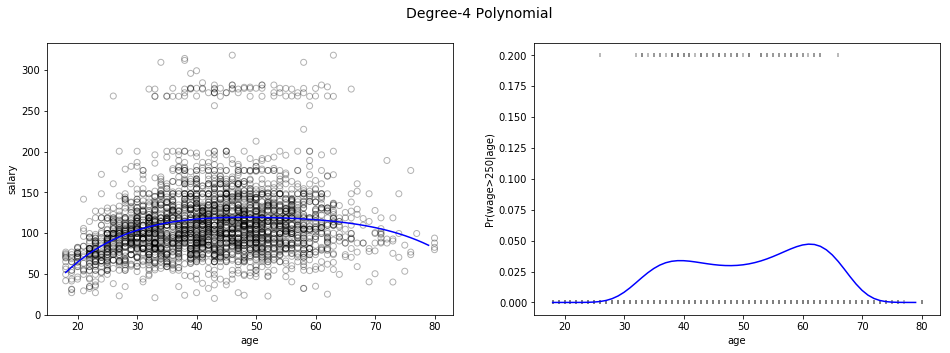

In [11]:
# creating plots
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (16,5))
fig.suptitle('Degree-4 Polynomial', fontsize=14)

# Scatter plot with polynomial regression line
ax1.scatter(df.age, df.wage, facecolor='None', edgecolor='k', alpha=0.3)
ax1.plot(age_grid, pred1, color = 'b')
ax1.set_ylim(ymin=0)
ax1.set_xlabel('age')
ax1.set_ylabel('salary')

# Logistic regression showing Pr(wage>250) for the age range.
ax2.plot(age_grid, pred2, color='b')

# Rug plot showing the distribution of wage>250 in the training data.
# 'True' on the top, 'False' on the bottom.
ax2.scatter(df.age, y/5, s=10, c='grey', marker='|', alpha=0.7)
ax2.set_ylim(-0.01,0.21)
ax2.set_xlabel('age')
ax2.set_ylabel('Pr(wage>250|age)')

## Deciding on a degree

### Question for you: How do you decide on the degree of your polynomial regression?



As an alternative to using hypothesis tests and Analysis of Variance (ANOVA), we could choose the polynomial degree using cross-validation as we have in previous labs.

## 2-Step functions
In order to fit a step function, we use the cut() function:

In [12]:
#retbins : bool, default False
#Whether to return the bins or not. Useful when bins is provided as a scalar.

#right : bool, default True
#Indicates whether bins includes the rightmost edge or not. 
#If right == True (the default), then the bins [1, 2, 3, 4] indicate (1,2], (2,3], (3,4]. 
#This argument is ignored when bins is an IntervalIndex.

df_cut, bins = pd.cut(df.age, 4, retbins = True, right = True)

In [13]:
print(df_cut.head())

0    (17.938, 33.5]
1    (17.938, 33.5]
2      (33.5, 49.0]
3      (33.5, 49.0]
4      (49.0, 64.5]
Name: age, dtype: category
Categories (4, interval[float64]): [(17.938, 33.5] < (33.5, 49.0] < (49.0, 64.5] < (64.5, 80.0]]


In [14]:
df_cut.value_counts(sort = False)

(17.938, 33.5]     750
(33.5, 49.0]      1399
(49.0, 64.5]       779
(64.5, 80.0]        72
Name: age, dtype: int64

In [15]:
print(bins)

[17.938 33.5   49.    64.5   80.   ]


Here cut() automatically picked the cutpoints at 33.5, 49, and 64.5 years of age. We could also have specified our own cutpoints directly. Now let's create a set of dummy variables for use in the regression:

In [16]:
df_steps = pd.concat([df.age, df_cut, df.wage], keys = ['age','age_cuts','wage'], axis = 1)
df_steps.head()

,age,age_cuts,wage
0,18,"(17.938, 33.5]",75.043154
1,24,"(17.938, 33.5]",70.476020
2,45,"(33.5, 49.0]",130.982177
3,43,"(33.5, 49.0]",154.685293
4,50,"(49.0, 64.5]",75.043154


In [17]:
# Create dummy variables for the age groups
df_steps_dummies = pd.get_dummies(df_steps['age_cuts'])

df_steps_dummies.head()

,"(17.938, 33.5]","(33.5, 49.0]","(49.0, 64.5]","(64.5, 80.0]"
0,1,0,0,0
1,1,0,0,0
2,0,1,0,0
3,0,1,0,0
4,0,0,1,0


In [18]:
# Statsmodels requires explicit adding of a constant (intercept)
df_steps_dummies = sm.add_constant(df_steps_dummies)

df_steps_dummies.head()

,const,"(17.938, 33.5]","(33.5, 49.0]","(49.0, 64.5]","(64.5, 80.0]"
0,1.0,1,0,0,0
1,1.0,1,0,0,0
2,1.0,0,1,0,0
3,1.0,0,1,0,0
4,1.0,0,0,1,0


In [19]:
# Drop the (17.938, 33.5] category
df_steps_dummies = df_steps_dummies.drop(df_steps_dummies.columns[1], axis = 1)

df_steps_dummies.head(5)

,const,"(33.5, 49.0]","(49.0, 64.5]","(64.5, 80.0]"
0,1.0,0,0,0
1,1.0,0,0,0
2,1.0,1,0,0
3,1.0,1,0,0
4,1.0,0,1,0


An now to fit the models! We dropped the age<33.5 category, so the intercept coefficient of $94,160 can be interpreted as the average salary for those under 33.5 years of age. The other coefficients can be interpreted as the average additional salary for those in the other age groups.

In [20]:
fit3 = sm.GLM(df_steps.wage, df_steps_dummies).fit()
fit3.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
const,94.1584,1.476,63.790,0.000,91.265,97.051
"(33.5, 49.0]",24.0535,1.829,13.148,0.000,20.468,27.639
"(49.0, 64.5]",23.6646,2.068,11.443,0.000,19.611,27.718
"(64.5, 80.0]",7.6406,4.987,1.532,0.126,-2.135,17.416


We can produce predictions and plots just as we did in the case of the polynomial fit.

In [21]:
# Put the test data in the same bins as the training data.
bin_mapping = np.digitize(age_grid.ravel(), bins)
bin_mapping

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

Text(0,0.5,'Pr(wage>250|age)')

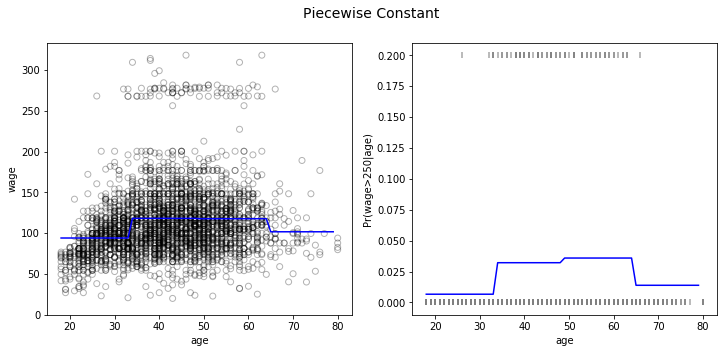

In [22]:
# Get dummies, drop first dummy category, add constant
X_test2 = sm.add_constant(pd.get_dummies(bin_mapping).drop(1, axis = 1))

# Predict the value of the generated ages using the linear model
pred2 = fit3.predict(X_test2)

# And the logistic model
clf2 = sm.GLM(y, df_steps_dummies,
              family=sm.families.Binomial(sm.families.links.logit))
res2 = clf2.fit()
pred3 = res2.predict(X_test2)

# Plot
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12,5))
fig.suptitle('Piecewise Constant', fontsize = 14)

# Scatter plot with polynomial regression line
ax1.scatter(df.age, df.wage, facecolor = 'None', edgecolor = 'k', alpha = 0.3)
ax1.plot(age_grid, pred2, c = 'b')

ax1.set_xlabel('age')
ax1.set_ylabel('wage')
ax1.set_ylim(ymin = 0)

# Logistic regression showing Pr(wage>250) for the age range.
ax2.plot(np.arange(df.age.min(), df.age.max()).reshape(-1,1), pred3, color = 'b')

# Rug plot showing the distribution of wage>250 in the training data.
# 'True' on the top, 'False' on the bottom.
ax2.scatter(df.age, y/5, s = 30, c = 'grey', marker = '|', alpha = 0.7)

ax2.set_ylim(-0.01, 0.21)
ax2.set_xlabel('age')
ax2.set_ylabel('Pr(wage>250|age)')

## Regression splines

In [23]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline

# Read in the data
df = pd.read_csv('data/Wage.csv')

# Generate a sequence of age values spanning the range
age_grid = np.arange(df.age.min(), df.age.max()).reshape(-1,1)
#print(age_grid)

In order to fit regression splines in python, we use the  𝚍𝚖𝚊𝚝𝚛𝚒𝚡  module from the  𝚙𝚊𝚝𝚜𝚢  library. The  𝚋𝚜()  function generates the entire matrix of basis functions for splines with the specified set of knots. Fitting  𝚠𝚊𝚐𝚎  to  𝚊𝚐𝚎  using a regression spline is simple:

In [24]:
from patsy import dmatrix

# Specifying 3 knots
transformed_x1 = dmatrix("bs(df.age, knots=(25,40,60), include_intercept=False)",
                        {"df.age": df.age}, return_type='dataframe')

In [25]:
# Build a regular linear model from the splines
fit1 = sm.GLM(df.wage, transformed_x1).fit()
fit1.params

Intercept                                                     60.493714
bs(df.age, knots=(25, 40, 60), include_intercept=False)[0]     3.980500
bs(df.age, knots=(25, 40, 60), include_intercept=False)[1]    44.630980
bs(df.age, knots=(25, 40, 60), include_intercept=False)[2]    62.838788
bs(df.age, knots=(25, 40, 60), include_intercept=False)[3]    55.990830
bs(df.age, knots=(25, 40, 60), include_intercept=False)[4]    50.688098
bs(df.age, knots=(25, 40, 60), include_intercept=False)[5]    16.606142
dtype: float64

Here we have prespecified knots at ages 25, 40, and 60. This produces a spline with six basis functions. (Recall that a cubic spline with three knots has seven degrees of freedom; these degrees of freedom are used up by an intercept, plus six basis functions.) We could also use the  𝚍𝚏  option to produce a spline with knots at uniform quantiles of the data:



In [26]:
# Specifying 6 degrees of freedom 
transformed_x2 = dmatrix("bs(df.age, df=6, include_intercept=False)",
                        {"df.age": df.age}, return_type='dataframe')
fit2 = sm.GLM(df.wage, transformed_x2).fit()
fit2.params

Intercept                                       56.313841
bs(df.age, df=6, include_intercept=False)[0]    27.824002
bs(df.age, df=6, include_intercept=False)[1]    54.062546
bs(df.age, df=6, include_intercept=False)[2]    65.828391
bs(df.age, df=6, include_intercept=False)[3]    55.812734
bs(df.age, df=6, include_intercept=False)[4]    72.131473
bs(df.age, df=6, include_intercept=False)[5]    14.750876
dtype: float64

In this case python chooses knots which correspond to the 25th, 50th, and 75th percentiles of  𝚊𝚐𝚎 . The function  𝚋𝚜()  also has a  𝚍𝚎𝚐𝚛𝚎𝚎  argument, so we can fit splines of any degree, rather than the default degree of 3 (which yields a cubic spline).



### Natural spline

In order to instead fit a natural spline, we use the  𝚌𝚛()  function. Here we fit a natural spline with four degrees of freedom:

In [27]:
# Specifying 4 degrees of freedom
transformed_x3 = dmatrix("cr(df.age, df=4)", {"df.age": df.age}, return_type='dataframe')
fit3 = sm.GLM(df.wage, transformed_x3).fit()
fit3.params

Intercept              79.642095
cr(df.age, df=4)[0]   -14.667784
cr(df.age, df=4)[1]    36.811142
cr(df.age, df=4)[2]    35.934874
cr(df.age, df=4)[3]    21.563863
dtype: float64

As with the  𝚋𝚜()  function, we could instead specify the knots directly using the  𝚔𝚗𝚘𝚝𝚜  option.


### Comaparison
Let's see how these three models stack up:

Text(0,0.5,'wage')

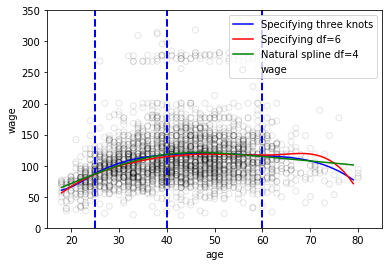

In [28]:
# Generate a sequence of age values spanning the range
age_grid = np.arange(df.age.min(), df.age.max()).reshape(-1,1)

# Make some predictions
pred1 = fit1.predict(dmatrix("bs(age_grid, knots=(25,40,60), include_intercept=False)",
                             {"age_grid": age_grid}, return_type='dataframe'))
pred2 = fit2.predict(dmatrix("bs(age_grid, df=6, include_intercept=False)",
                             {"age_grid": age_grid}, return_type='dataframe'))
pred3 = fit3.predict(dmatrix("cr(age_grid, df=4)", {"age_grid": age_grid}, return_type='dataframe'))

# Plot the splines and error bands
plt.scatter(df.age, df.wage, facecolor='None', edgecolor='k', alpha=0.1)
plt.plot(age_grid, pred1, color='b', label='Specifying three knots')
plt.plot(age_grid, pred2, color='r', label='Specifying df=6')
plt.plot(age_grid, pred3, color='g', label='Natural spline df=4')
[plt.vlines(i , 0, 350, linestyles='dashed', lw=2, colors='b') for i in [25,40,60]]
plt.legend()
plt.xlim(15,85)
plt.ylim(0,350)
plt.xlabel('age')
plt.ylabel('wage')